Метрикой качества в данной задаче является метрика **ROC-AUC**  
Формат вектор прогнозов представлен в файле sample_submit.csv   
#### Описание источников данных: 

train.csv - пары "заявка - целевая переменная", для этой выборки нужно собрать признаки и обучить модель;  
test.csv - пары "заявки - прогнозное значение", для этой выборки нужно собрать признаки и построить прогнозы;  
bki.csv - данные БКИ о предыдущих кредитах клиента;  
client_profile.csv - клиентский профиль, некоторые знания, которые есть у компании о клиенте;  
payments.csv - история платежей клиента;  
applications_history.csv - история предыдущих заявок клиента.  


#### Описание задачи:  
Для построения модели в данном соревновании, сначала нужно будет собрать выборку для обучения модели.  
Формат соревнования очень похож на то, как в промышленности Data Scinetist'ы строят алгоритмы: сначала нужно провести анализ данных, собрать выборку и после этого строить модели.   
В соревновании представлены 4 типа источника данных, которые могут быть интерпретированы как таблицы в базе данных.  Некоторые источники данных уже готовы для моделирования, представлены в агрерированном виде. Другие источники данных требуется представить в удобном для модели виде.

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import missingno as msno
import lightgbm as lgb
import catboost as cb
from sklearn import metrics
import seaborn as sns
from scipy.stats import probplot, ks_2samp
import warnings
from tqdm import tqdm
from typing import List, Tuple
from scipy.stats import ttest_rel
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score,GroupKFold,TimeSeriesSplit
from classes_and_functions import lgb_param_rnd_test,cb_param_rnd_test,make_cross_validation,make_cross_validation_cb
from  lightgbm import LGBMClassifier
from sklearn.inspection import permutation_importance

warnings.simplefilter("ignore")
%matplotlib inline
pd.set_option('display.max_columns', None)

In [3]:
PATCH = r'D:\train\kagle/'
patch_train = PATCH + 'train.csv'
patch_test = PATCH + 'test.csv'
patch_bki = PATCH + 'bki.csv'
patch_client_profile = PATCH + 'client_profile.csv'
patch_payments = PATCH + 'payments.csv'
patch_applications_history = PATCH + 'applications_history.csv'
patch_samble_submit = PATCH + 'sample_submit.csv'


In [ ]:
# Загрузить готовые данные
w_train = pd.read_csv(PATCH + 'w_train_cl_1.csv')
w_test = pd.read_csv(PATCH + 'w_test_cl_1.csv')
train= pd.read_csv(PATCH + 'train.csv')
cat_columns = w_train.select_dtypes(exclude=[np.number]).columns.to_list()
w_train[cat_columns] = w_train[cat_columns].astype(str)
w_test[cat_columns] = w_test[cat_columns].astype(str)
w_train[cat_columns] = w_train[cat_columns].astype('category')
w_test[cat_columns] = w_test[cat_columns].astype('category')

Осмотрим данные

In [4]:
# как сдавать результаты
pd.read_csv(patch_samble_submit)


,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0
2,123428178,0
3,123619984,0
4,123671104,0
...,...,...
165136,123487967,0
165137,123536402,0
165138,123718238,0
165139,123631557,0


In [4]:
test = pd.read_csv(patch_test)
test

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card
3,123619984,Cash
4,123671104,Cash
...,...,...
165136,123487967,Cash
165137,123536402,Cash
165138,123718238,Cash
165139,123631557,Cash


In [6]:

test.NAME_CONTRACT_TYPE.value_counts()

Cash           149432
Credit Card     15709
Name: NAME_CONTRACT_TYPE, dtype: int64

In [7]:
sum(test.APPLICATION_NUMBER.duplicated())

0

Дубликатов нет

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  165141 non-null  int64 
 1   NAME_CONTRACT_TYPE  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


In [11]:
test.APPLICATION_NUMBER.sort_values()

85962     123423342
127477    123423343
129290    123423344
55321     123423346
158817    123423347
            ...    
142454    123730847
141662    123730848
75755     123730849
9566      123730850
76629     123730851
Name: APPLICATION_NUMBER, Length: 165141, dtype: int64

Все заявки в тесте уникальны. Заявки могут быть на наличный и кредитные карты. Нужно дать ответ по 165 141 заявке. Вероятность от  0 до 1   (поскольку метрика ROC-AUC)
Похоже , что заявки имеют сквозную нумерацию. Это значить, что в номере заявки заложена информация о времени. При этом видно, что заявки перемешаны

In [5]:
train = pd.read_csv(patch_train)
train

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash
...,...,...,...
110088,123458312,0,Cash
110089,123672463,0,Cash
110090,123723001,0,Cash
110091,123554358,0,Cash


In [13]:
train.NAME_CONTRACT_TYPE.value_counts()

Cash           99551
Credit Card    10542
Name: NAME_CONTRACT_TYPE, dtype: int64

In [14]:
sum(test.APPLICATION_NUMBER.duplicated())

0

Дубликатов нет

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [16]:
train.APPLICATION_NUMBER.sort_values()

47058     123423341
6474      123423345
2373      123423349
78690     123423351
21529     123423352
            ...    
102567    123730828
82146     123730830
38743     123730833
38221     123730838
26422     123730843
Name: APPLICATION_NUMBER, Length: 110093, dtype: int64

Все заявки в трейне уникальны. Заявки могут быть на наличный и кредитные карты. Имеется  110093 заявки ждя обучения с таргетом 0 или 1  
Похоже , что заявки имеют сквозную нумерацию. Это значить, что в номере заявки заложена информация о времени. При этом видно, что заявки перемешаны

In [17]:
train.TARGET.value_counts(),train.TARGET.value_counts(normalize=True)

(0    101196
 1      8897
 Name: TARGET, dtype: int64,
 0    0.919187
 1    0.080813
 Name: TARGET, dtype: float64)

Доля положительного таргета очень маленькая, всего 8%. около 9000 строк всего

In [6]:
client = pd.read_csv(patch_client_profile)
client

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,365243,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,326,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,1726,12.0,0,0,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,365243,NaN,0,0,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,123657254,M,0,216000.0,45000.0,2425.5,Higher education,Married,0.018850,19150,7415,NaN,0,1,2.0,0.555436,0.581592,0.048259,0.0,0.0,0.0,0.0,1.0,3.0
249996,123645397,M,0,103500.0,675000.0,28507.5,Higher education,Married,0.014520,19604,1799,16.0,0,0,2.0,NaN,0.676409,0.726711,0.0,0.0,0.0,0.0,0.0,0.0
249997,123504053,M,0,202500.0,1078200.0,38331.0,Secondary / secondary special,Single / not married,0.031329,8351,124,12.0,0,0,1.0,NaN,0.353665,0.283712,0.0,0.0,0.0,0.0,1.0,4.0
249998,123547316,F,0,135000.0,500211.0,38839.5,Secondary / secondary special,Married,0.030755,13277,1603,NaN,0,1,2.0,0.305746,0.682462,0.639708,0.0,0.0,0.0,0.0,0.0,3.0


в файле видим некторые данные о клиенте привязанную к заявке. Это уже хорошо. Значть данные были источески актуальны на мамент подачи заявки

In [39]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [40]:
sum(client.APPLICATION_NUMBER.duplicated())

0

Не дублей по заявкам

Проверим как покрывают эти данные тест и трейн (тест и трейн в сумме 275 234 записей, в даннойм файле у нас всего 250 000 записей)

In [13]:
all_app = pd.concat((test.APPLICATION_NUMBER , train.APPLICATION_NUMBER))

In [14]:
sum(all_app.duplicated())

0

На трейне и тесте нет повторяющихся заявок :)

In [7]:
def is_client_info(df,df_f):
    w_df = df.copy()
    d_map_app_index_client_test = {i:1 for  i in df_f.APPLICATION_NUMBER.values}
    w_df['is_client_info'] = w_df.APPLICATION_NUMBER.map(d_map_app_index_client_test)
    w_df['is_client_info'] = w_df['is_client_info'].fillna(0)
    w_df['is_client_info'] = w_df['is_client_info'].astype(int)
    
    return w_df



In [8]:
w_test = is_client_info(test,client)

In [9]:
w_train = is_client_info(train,client)

In [18]:
w_train.is_client_info.value_counts(),w_train.is_client_info.value_counts(normalize = True)

(1    89539
 0    20554
 Name: is_client_info, dtype: int64,
 1    0.813303
 0    0.186697
 Name: is_client_info, dtype: float64)

In [19]:
w_test.is_client_info.value_counts(),w_test.is_client_info.value_counts(normalize = True)

(1    134176
 0     30965
 Name: is_client_info, dtype: int64,
 1    0.812494
 0    0.187506
 Name: is_client_info, dtype: float64)

Как видно на тесте не хватает данных о клдиентах по 30 965 заявкам  
На трейне 20 554 з0аявки без данных о клиенте  
в обоих случаях это 18 %


In [58]:
client

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,365243,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,326,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,1726,12.0,0,0,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,365243,NaN,0,0,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,123657254,M,0,216000.0,45000.0,2425.5,Higher education,Married,0.018850,19150,7415,NaN,0,1,2.0,0.555436,0.581592,0.048259,0.0,0.0,0.0,0.0,1.0,3.0
249996,123645397,M,0,103500.0,675000.0,28507.5,Higher education,Married,0.014520,19604,1799,16.0,0,0,2.0,NaN,0.676409,0.726711,0.0,0.0,0.0,0.0,0.0,0.0
249997,123504053,M,0,202500.0,1078200.0,38331.0,Secondary / secondary special,Single / not married,0.031329,8351,124,12.0,0,0,1.0,NaN,0.353665,0.283712,0.0,0.0,0.0,0.0,1.0,4.0
249998,123547316,F,0,135000.0,500211.0,38839.5,Secondary / secondary special,Married,0.030755,13277,1603,NaN,0,1,2.0,0.305746,0.682462,0.639708,0.0,0.0,0.0,0.0,0.0,3.0


In [10]:
def encode_features(test,name,train):
    con = pd.concat([train,test])
    d_un = con[name].unique()
    dict_uniq = {}
    for j,i in enumerate(d_un):
        dict_uniq[i]=j
        
    train[f'{name}_1'] = train[name].map(dict_uniq)
    test[f'{name}_1'] = test[name].map(dict_uniq)
    
    
    test[f'{name}_2'] = test[name].map(con[name].value_counts())
    train[f'{name}_2'] = train[name].map(con[name].value_counts())
    
    
    train[f'{name}_3'] = train[name].map(train[train.TARGET==1][name].value_counts())
    test[f'{name}_3'] = test[name].map(train[train.TARGET==1][name].value_counts())
    

In [11]:
def create_client_profile_features(df):
    w_df = df.copy()
    
    w_df.DAYS_ON_LAST_JOB = w_df.DAYS_ON_LAST_JOB.replace(365243,np.nan)
    bki_flags = [flag for flag in w_df.columns if 'CREDIT_BUREAU' in flag]
    w_df['bki_requests_count'] = w_df[bki_flags].sum(axis = 1)
    w_df['bki_kurtosis'] = w_df[bki_flags].kurtosis(axis = 1)
    w_df['bki_skew'] = w_df[bki_flags].skew(axis = 1)
    
    w_df['external_scoring_prod'] = \
        w_df.EXTERNAL_SCORING_RATING_1*w_df.EXTERNAL_SCORING_RATING_2*w_df.EXTERNAL_SCORING_RATING_3
    
    w_df['external_scoring_weighet'] = \
        w_df.EXTERNAL_SCORING_RATING_1*2 + w_df.EXTERNAL_SCORING_RATING_2*1 +  w_df.EXTERNAL_SCORING_RATING_3*3
    
    
    for funktion_name in ['mean','max','std','median','nanmedian']:
        f_name = f'ESR_{funktion_name}'
        w_df[f_name] = eval(f'np.{funktion_name}')\
            (w_df[['EXTERNAL_SCORING_RATING_1','EXTERNAL_SCORING_RATING_2','EXTERNAL_SCORING_RATING_3']],axis= 1)
        
    w_df['am_to_ann'] = w_df.AMOUNT_CREDIT/w_df.AMOUNT_ANNUITY
    w_df['ann_to_sal'] = w_df.AMOUNT_ANNUITY/w_df.TOTAL_SALARY
    w_df['sal_to_ann'] = w_df.TOTAL_SALARY/w_df.AMOUNT_ANNUITY
    w_df['cr_to_sal'] = w_df.AMOUNT_CREDIT/w_df.TOTAL_SALARY
    w_df['sal_to_cr'] = w_df.TOTAL_SALARY /w_df.AMOUNT_CREDIT  
    
    w_df['an_to_age'] = w_df.AMOUNT_ANNUITY/w_df.AGE
    w_df['cr_to_age'] = w_df.AMOUNT_CREDIT/w_df.AGE
    w_df['sal_to_age'] = w_df.TOTAL_SALARY/w_df.AGE
    w_df['sal_to_exp'] = w_df.TOTAL_SALARY/w_df.DAYS_ON_LAST_JOB
    w_df['cr_to_exp'] = w_df.AMOUNT_CREDIT /w_df.DAYS_ON_LAST_JOB 
    w_df['ann_to_exp'] = w_df.AMOUNT_ANNUITY /w_df.DAYS_ON_LAST_JOB 
    
    
    
    w_df['age_to_exp'] = w_df.AGE/w_df.DAYS_ON_LAST_JOB
    w_df['sal_to_reg'] = w_df.TOTAL_SALARY/w_df.REGION_POPULATION
    w_df['car_to_exp'] = w_df.OWN_CAR_AGE /w_df.DAYS_ON_LAST_JOB 
    w_df['car_to_age'] = w_df.OWN_CAR_AGE /w_df.AGE 
    
    w_df['asr_1*cr'] = w_df.EXTERNAL_SCORING_RATING_1*w_df.AMOUNT_CREDIT
    w_df['asr_2*cr'] = w_df.EXTERNAL_SCORING_RATING_2*w_df.AMOUNT_CREDIT
    w_df['asr_3*cr'] = w_df.EXTERNAL_SCORING_RATING_3*w_df.AMOUNT_CREDIT
    w_df['asr_1*an'] = w_df.EXTERNAL_SCORING_RATING_1*w_df.AMOUNT_ANNUITY
    w_df['asr_2*an'] = w_df.EXTERNAL_SCORING_RATING_2*w_df.AMOUNT_ANNUITY
    w_df['asr_3*an'] = w_df.EXTERNAL_SCORING_RATING_3*w_df.AMOUNT_ANNUITY
    
    
    w_df['am_per_fs'] = w_df.AMOUNT_CREDIT/ w_df.FAMILY_SIZE
    w_df['am_per_ch'] = w_df.AMOUNT_CREDIT/(1+w_df.CHILDRENS)
    w_df['ad'] = w_df.FAMILY_SIZE - w_df.CHILDRENS 
    
    w_df['sal_fs'] = w_df.TOTAL_SALARY/ w_df.FAMILY_SIZE
    w_df['sal_ch'] = w_df.TOTAL_SALARY/ (1+w_df.CHILDRENS)
    w_df['sal_per_ad'] = w_df.TOTAL_SALARY /(1+w_df['ad'])
    w_df['cr_per_ad'] = w_df.AMOUNT_CREDIT /(1+w_df['ad'])
    w_df['an_per_ad'] = w_df.AMOUNT_ANNUITY /(1+w_df['ad']) 
    w_df['an_per_ch'] = w_df.AMOUNT_ANNUITY /(1+w_df.CHILDRENS)
    
    
    return  w_df   
        
        
    

In [12]:
w_client = create_client_profile_features(client)

In [17]:
w_client

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bki_requests_count,bki_kurtosis,bki_skew,external_scoring_prod,external_scoring_weighet,ESR_mean,ESR_max,ESR_std,ESR_median,ESR_nanmedian,am_to_ann,ann_to_sal,sal_to_ann,cr_to_sal,sal_to_cr,an_to_age,cr_to_age,sal_to_age,sal_to_exp,cr_to_exp,ann_to_exp,age_to_exp,sal_to_reg,car_to_exp,car_to_age,asr_1*cr,asr_2*cr,asr_3*cr,asr_1*an,asr_2*an,asr_3*an,am_per_fs,am_per_ch,ad,sal_fs,sal_ch,sal_per_ad,cr_per_ad,an_per_ad,an_per_ch
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0,3.0,1.428571,1.536722,0.052832,2.930959,0.414784,0.678568,0.190361,0.329471,0.329471,20.000000,0.085714,11.666667,1.714286,0.583333,1.577103,31.542056,18.399533,101.678502,174.306004,8.715300,5.526146,1.952157e+07,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797,135000.00,270000.0,2.0,78750.0,157500.0,52500.0,90000.0,4500.00,13500.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-1.875000,0.968246,NaN,NaN,0.622520,0.802745,0.180225,NaN,0.622520,18.861050,0.105433,9.484666,1.988583,0.502871,1.227714,23.155971,11.644456,NaN,NaN,NaN,NaN,1.333597e+07,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462,268458.75,536917.5,2.0,135000.0,270000.0,90000.0,178972.5,9489.00,28467.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,326.0,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.573588,0.738159,0.164571,NaN,0.573588,10.056604,0.055789,17.924528,0.561053,1.782364,1.657747,16.671300,29.714325,1311.349693,735.736196,73.159509,44.131902,5.895901e+06,0.055215,0.001251,98102.721947,177047.426953,NaN,9755.054903,17605.091235,NaN,79950.00,119925.0,2.0,142500.0,213750.0,142500.0,79950.0,7950.00,11925.0
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,1726.0,12.0,0,0,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0,3.0,6.000000,2.449490,NaN,NaN,0.449613,0.590233,0.140620,NaN,0.449613,14.851745,0.152440,6.559958,2.264000,0.441696,1.201534,17.844882,7.882015,65.179606,147.566628,9.935979,8.269409,5.889744e+06,0.006952,0.000841,NaN,78700.652830,150332.431346,NaN,5299.084593,10122.206641,127350.00,254700.0,2.0,56250.0,112500.0,37500.0,84900.0,5716.50,17149.5
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,NaN,NaN,0,0,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0,7.0,5.393765,2.308395,NaN,NaN,0.448024,0.739408,0.291384,NaN,0.448024,31.003859,0.151897,6.583428,4.709379,0.212342,0.863575,26.774157,5.685284,NaN,NaN,NaN,NaN,5.767956e+06,NaN,NaN,NaN,454420.991996,96266.765058,NaN,14656.917009,3104.992971,307287.00,614574.0,2.0,65250.0,130500.0,43500.0,204858.0,6607.50,19822.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,123657254,M,0,216000.0,45000.0,2425.5,Higher education,Married,0.018850,19150,7415.0,NaN,0,1,2.0,0.555436,0.581592,0.048259,0.0,0.0,0.0,0.0,1.0,3.0,4.0,3.657025,1.951708,0.015589,1.837242,0.395096,0.581592,0.245483,0.555436,0.555436,18.552876,0.011229,89.053803,0.208333,4.800000,0.126658,2.349869,11.279373,29.130142,6.068780,0.327107,2.582603,1.145889e+07,NaN,NaN,24994.637022,26171.632545,2171.654256,1347.2109

In [13]:
w_client.replace([np.inf, -np.inf], np.nan, inplace=True)

In [14]:
w_train = w_train.merge(w_client,how='left',on = 'APPLICATION_NUMBER')

In [15]:
w_test = w_test.merge(w_client,how='left',on = 'APPLICATION_NUMBER')

In [16]:
w_train.replace([np.inf, -np.inf], np.nan, inplace=True)
w_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [17]:
%%time
cat_columns = w_train.select_dtypes(exclude=[np.number]).columns.to_list()
w_train[cat_columns] = w_train[cat_columns].astype(str)
w_test[cat_columns] = w_test[cat_columns].astype(str)
w_train[cat_columns] = w_train[cat_columns].astype('category')
w_test[cat_columns] = w_test[cat_columns].astype('category')

Wall time: 121 ms


In [32]:
for i in cat_columns:
    encode_features(w_test,i,w_train)

In [19]:
w_test

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,is_client_info,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bki_requests_count,bki_kurtosis,bki_skew,external_scoring_prod,external_scoring_weighet,ESR_mean,ESR_max,ESR_std,ESR_median,ESR_nanmedian,am_to_ann,ann_to_sal,sal_to_ann,cr_to_sal,sal_to_cr,an_to_age,cr_to_age,sal_to_age,sal_to_exp,cr_to_exp,ann_to_exp,age_to_exp,sal_to_reg,car_to_exp,car_to_age,asr_1*cr,asr_2*cr,asr_3*cr,asr_1*an,asr_2*an,asr_3*an,am_per_fs,am_per_ch,ad,sal_fs,sal_ch,sal_per_ad,cr_per_ad,an_per_ad,an_per_ch,NAME_CONTRACT_TYPE_1,NAME_CONTRACT_TYPE_2,NAME_CONTRACT_TYPE_3,GENDER_1,GENDER_2,GENDER_3,EDUCATION_LEVEL_1,EDUCATION_LEVEL_2,EDUCATION_LEVEL_3,FAMILY_STATUS_1,FAMILY_STATUS_2,FAMILY_STATUS_3
0,123724268,Cash,1,M,0.0,117000.0,1125000.0,32895.0,Secondary / secondary special,Married,0.028663,16007.0,2646.0,20.0,0.0,0.0,2.0,NaN,0.628266,NaN,0.0,0.0,0.0,0.0,1.0,4.0,5.0,4.639906,2.148179,NaN,NaN,0.628266,0.628266,0.000000,NaN,0.628266,34.199726,0.281154,3.556772,9.615385,0.104000,2.055038,70.281752,7.309302,44.217687,425.170068,12.431973,6.049509,4.081917e+06,0.007559,0.001249,NaN,706799.427892,NaN,NaN,20666.815272,NaN,562500.00,1125000.0,2.0,58500.0,117000.0,39000.0,375000.0,10965.00,32895.0,0,248983,8322,0,76267,3046,0,158887,5690,0,143149,4321
1,123456549,Cash,1,F,2.0,81000.0,312768.0,17095.5,Secondary / secondary special,Married,0.019689,10315.0,459.0,NaN,0.0,0.0,4.0,NaN,0.578161,0.188490,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,1.536722,NaN,NaN,0.383325,0.578161,0.194836,NaN,0.383325,18.295341,0.211056,4.738089,3.861333,0.258978,1.657344,30.321667,7.852642,176.470588,681.411765,37.245098,22.472767,4.113972e+06,NaN,NaN,NaN,180830.265914,58953.494506,NaN,9883.951718,3222.322825,78192.00,104256.0,2.0,20250.0,27000.0,27000.0,104256.0,5698.50,5698.5,0,248983,8322,2,147444,4162,0,158887,5690,0,143149,4321
2,123428178,Credit Card,1,F,2.0,157500.0,450000.0,22500.0,Secondary / secondary special,Married,0.019101,13016.0,977.0,NaN,1.0,0.0,4.0,NaN,0.152544,0.382502,0.0,0.0,0.0,0.0,1.0,6.0,7.0,5.393765,2.308395,NaN,NaN,0.267523,0.382502,0.114979,NaN,0.267523,20.000000,0.142857,7.000000,2.857143,0.350000,1.728642,34.572833,12.100492,161.207779,460.593654,23.029683,13.322416,8.245642e+06,NaN,NaN,NaN,68644.984320,172125.811865,NaN,3432.249216,8606.290593,112500.00,150000.0,2.0,39375.0,52500.0,52500.0,150000.0,7500.00,7500.0,1,26251,575,2,147444,4162,0,158887,5690,0,143149,4321
3,123619984,Cash,0,nan,NaN,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,248983,8322,1,51519,1689,1,51519,1689,1,51519,1689
4,123671104,Cash,1,F,1.0,90000.0,254700.0,24939.0,Higher education,Married,0.015221,17743.0,9258.0,NaN,1.0,0.0,3.0,0.718604,0.505704,0.415347,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.000000,2.449490,0.150937,3.188953,0.546552,0.718604,0.127129,0.505704,0.505704,10.212920,0.277100,3.608805,2.830000,0.353357,1.405568,14.354957,5.072423,9.721322,27.511342,2.693778,1.916505,5.912884e+06,NaN,NaN,183028.441193,128802.709015,105788.917802,17921.26539,12611.742286,10358.342446,84900.00,127350.0,2.0,30000.0,45000.0,30000.0,84900.0,8313.00,12469.5,0,248983,8322,2,147444,4162,2,54516,1131,0,143149,4321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [33]:
w_train.replace([np.inf, -np.inf], np.nan, inplace=True)
w_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [20]:
w_train

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,is_client_info,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bki_requests_count,bki_kurtosis,bki_skew,external_scoring_prod,external_scoring_weighet,ESR_mean,ESR_max,ESR_std,ESR_median,ESR_nanmedian,am_to_ann,ann_to_sal,sal_to_ann,cr_to_sal,sal_to_cr,an_to_age,cr_to_age,sal_to_age,sal_to_exp,cr_to_exp,ann_to_exp,age_to_exp,sal_to_reg,car_to_exp,car_to_age,asr_1*cr,asr_2*cr,asr_3*cr,asr_1*an,asr_2*an,asr_3*an,am_per_fs,am_per_ch,ad,sal_fs,sal_ch,sal_per_ad,cr_per_ad,an_per_ad,an_per_ch,NAME_CONTRACT_TYPE_1,NAME_CONTRACT_TYPE_2,NAME_CONTRACT_TYPE_3,GENDER_1,GENDER_2,GENDER_3,EDUCATION_LEVEL_1,EDUCATION_LEVEL_2,EDUCATION_LEVEL_3,FAMILY_STATUS_1,FAMILY_STATUS_2,FAMILY_STATUS_3
0,123687442,0,Cash,1,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,1.536722,0.324353,4.197193,0.687756,0.716570,0.030281,0.700784,0.700784,34.025788,0.159543,6.267908,5.428571,0.184211,1.597660,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,8.245642e+06,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,285000.0,427500.0,2.0,52500.0,78750.0,52500.0,285000.0,8376.0,12564.0,0,248983,8322,0,76267,3046,0,158887,5690,0,143149,4321
1,123597908,1,Cash,0,nan,NaN,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,248983,8322,1,51519,1689,1,51519,1689,1,51519,1689
2,123526683,0,Cash,1,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,11.0,0.539379,1.379260,NaN,NaN,0.475009,0.682149,0.207140,NaN,0.475009,23.603376,0.316000,3.164557,7.458667,0.134072,1.978940,46.709653,6.262467,37.313433,278.308458,11.791045,5.958264,5.115186e+06,NaN,NaN,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803,503460.0,1006920.0,2.0,67500.0,135000.0,45000.0,335640.0,14220.0,42660.0,0,248983,8322,2,147444,4162,2,54516,1131,0,143149,4321
3,123710391,1,Cash,1,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,0.031329,22338.0,NaN,NaN,0.0,0.0,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,NaN,0.170873,0.171299,0.000426,NaN,0.170873,22.573164,0.127625,7.835455,2.880900,0.347114,1.028405,23.214343,8.058018,NaN,NaN,NaN,NaN,5.745475e+06,NaN,NaN,NaN,88829.188848,88386.882459,NaN,3935.167908,3915.573562,259281.0,518562.0,2.0,90000.0,180000.0,60000.0,172854.0,7657.5,22972.5,0,248983,8322,0,76267,3046,0,158887,5690,0,143149,4321
4,123590329,1,Cash,0,nan,NaN,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,248983,8322,1,51519,1689,1,51519,1689,1,51519,1689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,0,nan,NaN,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [34]:
%%time
cat_columns = w_train.select_dtypes(exclude=[np.number]).columns.to_list()
w_train[cat_columns] = w_train[cat_columns].astype(str)
w_test[cat_columns] = w_test[cat_columns].astype(str)
w_train[cat_columns] = w_train[cat_columns].astype('category')
w_test[cat_columns] = w_test[cat_columns].astype('category')

Wall time: 989 ms


In [35]:
x,x_v, y,y_v = train_test_split(w_train.drop('TARGET',axis = 1),w_train['TARGET'],\
                                                 test_size= 0.2,random_state = 41,stratify = w_train['TARGET'] )

In [20]:
cv_strategy = StratifiedKFold(n_splits=5,random_state = 41,shuffle =True)

In [36]:
model_lgb = lgb.LGBMClassifier(objective= "binary" ,metric= "auc", 
                                 n_jobs= 15)


model_cb = cb.CatBoostClassifier(loss_function= "Logloss",
#                                 task_type= "GPU",
#                                 devices='0',     
                                verbose=False , 
                                eval_metric= "AUC",
                                thread_count= 15,
                                cat_features = cat_columns)

In [37]:
%%time
res =make_cross_validation(w_train.drop('TARGET',axis = 1),\
                           w_train['TARGET'],model_lgb, roc_auc_score, cv_strategy)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7874, valid-score = 0.7281
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.8386, valid-score = 0.7257
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7791, valid-score = 0.7218
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.8395, valid-score = 0.716
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.8344, valid-score = 0.7231
CV-results train: 0.8158 +/- 0.027
CV-results valid: 0.7229 +/- 0.004
OOF-score = 0.7224
Wall time: 4.58 s


In [38]:
%%time
model_lgb.fit(x,y)
pred = model_lgb.predict_proba(x_v)[:,1]
roc_auc_score(y_v,pred)

Wall time: 634 ms


0.7178413423404808

In [39]:
%%time
c = make_cross_validation_cb(w_train.drop('TARGET',axis = 1),\
                           w_train['TARGET'],model_cb, roc_auc_score, cv_strategy)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7789, valid-score = 0.729
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7747, valid-score = 0.7322
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7729, valid-score = 0.726
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7872, valid-score = 0.7189
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7745, valid-score = 0.7248
CV-results train: 0.7777 +/- 0.005
CV-results valid: 0.7262 +/- 0.004
OOF-score = 0.7259
Wall time: 2min 12s


In [40]:
%%time
model_cb.fit(x,y)
pred = model_cb.predict_proba(x_v)[:,1]
roc_auc_score(y_v,pred)

Wall time: 1min 23s


0.7201678369959585

#### Подбор для lgb

In [30]:
lgb_param_rnd_test(x,y,x_v,y_v,100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:45<00:00,  2.26s/it]


,boosting_type,objective,num_leaves,max_depth,learning_rate,metric,n_jobs,reg_alpha,reg_lambda,n_estimators,random_state,auc
72,gbdt,binary,70.0,2.0,0.20,auc,15.0,4.0,50.0,1000.0,27.0,0.723748
5,gbdt,binary,12.0,15.0,0.10,auc,15.0,4.0,12.0,1000.0,27.0,0.723686
65,gbdt,binary,7.0,8.0,0.20,auc,15.0,6.0,20.0,1000.0,27.0,0.723679
75,gbdt,binary,5.0,7.0,0.30,auc,15.0,12.0,15.0,1000.0,27.0,0.723640
49,gbdt,binary,12.0,13.0,0.05,auc,15.0,2.0,20.0,1000.0,27.0,0.723369
...,...,...,...,...,...,...,...,...,...,...,...,...
39,gbdt,binary,30.0,5.0,0.01,auc,15.0,300.0,12.0,1000.0,27.0,0.699827
94,gbdt,binary,2.0,11.0,0.05,auc,15.0,300.0,6.0,1000.0,27.0,0.699695
38,gbdt,binary,45.0,11.0,0.20,auc,15.0,300.0,1.0,1000.0,27.0,0.699267
60,gbdt,binary,25.0,16.0,0.20,auc,15.0,300.0,100.0,1000.0,27.0,0.699168


In [41]:
params_lgb = {
        "boosting_type": "gbdt",
        "objective": "binary",
        'num_leaves':5,
        'max_depth':2,
        'learning_rate':0.05,
        "metric": "auc",
        "n_jobs": 15,
        'reg_alpha':0.5,
        'reg_lambda':300,
        'n_estimators':5000 }


In [42]:
model_lgb = lgb.LGBMClassifier(**params_lgb)

In [43]:
%%time
res =make_cross_validation(w_train.drop('TARGET',axis = 1),\
                           w_train['TARGET'],model_lgb, roc_auc_score, cv_strategy)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7334, valid-score = 0.7289
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7363, valid-score = 0.7301
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7392, valid-score = 0.7269
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7374, valid-score = 0.7173
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7454, valid-score = 0.7288
CV-results train: 0.7383 +/- 0.004
CV-results valid: 0.7264 +/- 0.005
OOF-score = 0.726
Wall time: 18.1 s


In [44]:
for i in res[0]:
    print(i.best_iteration_)

1107
1107
1107
1107
1107


In [45]:
params_lgb['n_estimators']= 1900
model_lgb = lgb.LGBMClassifier(**params_lgb)

In [46]:
%%time
result  = []
for i in range(50):
    x,x_v, y,y_v = train_test_split(w_train.drop('TARGET',axis = 1),w_train['TARGET'],\
                                                     test_size= 0.2,random_state = i)
    model_lgb.fit(x,y)
    pred = model_lgb.predict_proba(x_v)[:,1]
    result.append(roc_auc_score(y_v,pred))
result = np.array(result)
result.mean(),result.std(),result.min(),result.max()

Wall time: 3min 6s


(0.7305625014630388,
 0.005900274090473909,
 0.7193770652972089,
 0.744863095514288)

### Посмотрим что лишнее

In [55]:
%%time
x,x_v, y,y_v = train_test_split(w_train.drop('TARGET',axis = 1),w_train['TARGET'],\
                                                 test_size= 0.2,random_state = 41,stratify = w_train['TARGET'] )

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb.fit(x,y)
pred =  model_lgb.predict_proba(x_v)[:,1]
print(roc_auc_score(y_v,pred))


importance = permutation_importance(
    model_lgb, x_v, y_v, scoring="roc_auc", n_jobs=15, random_state=27
)
importance_scores = pd.DataFrame({
    "features": x_v.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores
# decrease_scores = importance_scores[importance_scores["importance-mean"]>0.00001]
decrease_scores = decrease_scores.reset_index(drop=True)


0.7216589653778048
Wall time: 1min 5s


In [62]:
decrease_scores

,features,importance-mean,importance-std
0,ESR_mean,0.055055,0.004653
1,am_to_ann,0.016953,0.001460
2,EXTERNAL_SCORING_RATING_3,0.003502,0.001680
3,NAME_CONTRACT_TYPE,0.003488,0.001664
4,EDUCATION_LEVEL,0.002999,0.001554
...,...,...,...
73,sal_to_cr,-0.000531,0.000230
74,asr_3*an,-0.000574,0.000702
75,asr_1*cr,-0.000594,0.000339
76,sal_to_exp,-0.000634,0.000563


In [56]:
decrease_scores.to_csv(PATCH + 'decrease_scores_min_lgb_cl.csv',index=False)

In [57]:
decrease_scores.head(60)

,features,importance-mean,importance-std
0,ESR_mean,5.505529e-02,0.004653
1,am_to_ann,1.695269e-02,0.001460
2,EXTERNAL_SCORING_RATING_3,3.501684e-03,0.001680
3,NAME_CONTRACT_TYPE,3.487798e-03,0.001664
4,EDUCATION_LEVEL,2.999309e-03,0.001554
5,GENDER,2.906302e-03,0.000742
6,EXTERNAL_SCORING_RATING_1,2.167623e-03,0.001355
7,OWN_CAR_AGE,1.624539e-03,0.000423
8,REGION_POPULATION,1.246906e-03,0.000511
9,cr_to_age,1.058234e-03,0.000421


### Посмотрим как отличаются статистики на трейне и тесет по всем признакам

In [58]:
train_stats, test_stats = w_train.skew(), w_test.skew()
diff = np.abs(train_stats-test_stats)
my_diff_skew = diff[diff>10]
my_diff_skew

AMT_REQ_CREDIT_BUREAU_QRT    159.434757
TOTAL_SALARY                 300.796196
age_to_exp                   140.630566
ann_to_exp                    31.456842
car_to_exp                    77.287345
cr_to_exp                     80.429103
sal_ch                       217.901581
sal_fs                       200.342851
sal_per_ad                   286.054242
sal_to_age                   308.253818
sal_to_ann                   285.858592
sal_to_cr                    222.979722
sal_to_exp                    13.168155
sal_to_reg                   215.582382
dtype: float64

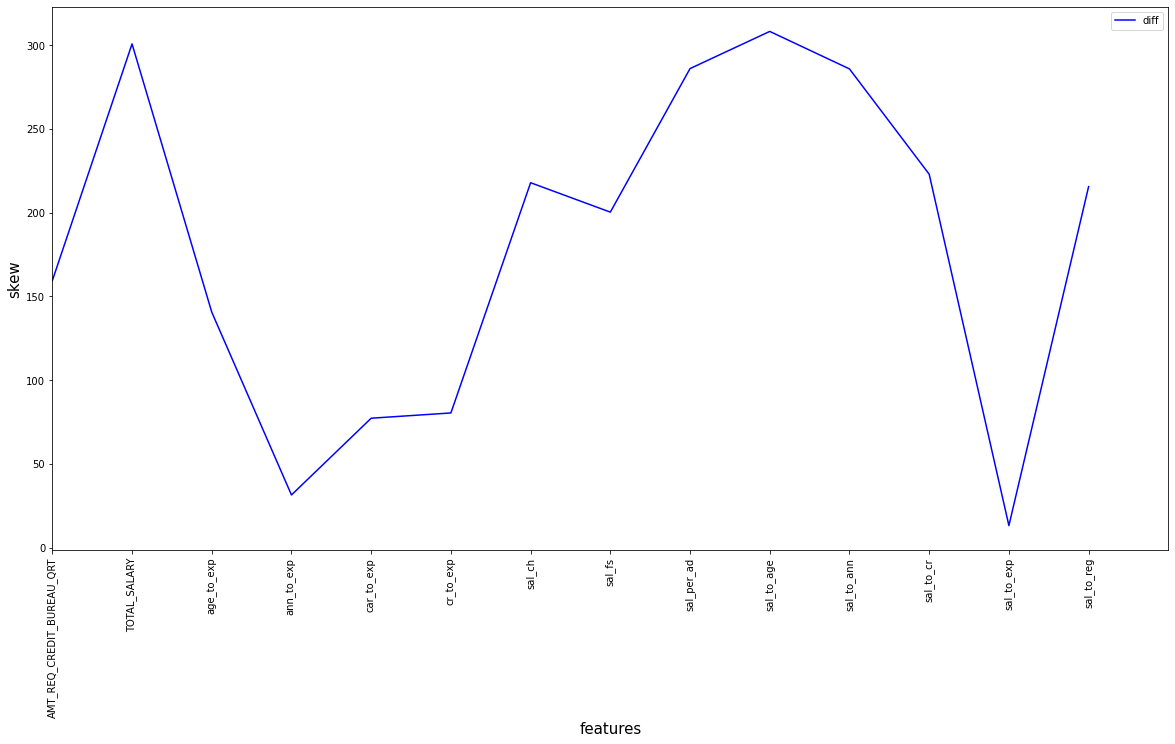

In [59]:
fig = plt.figure(figsize=(20, 10))
plt.plot(my_diff_skew, color="blue", label="diff")
plt.xticks(range(my_diff_skew.shape[0]), my_diff_skew.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(my_diff_skew))
plt.ylabel("skew", size=15)
plt.legend(loc="best") 
plt.show()

In [60]:
train_stats, test_stats = w_train.kurtosis(), w_test.kurtosis()
diff = np.abs(train_stats-test_stats)
my_diff_kurtosis = diff[diff>1000]
my_diff_kurtosis

AMT_REQ_CREDIT_BUREAU_QRT     42877.402455
TOTAL_SALARY                 105439.885693
age_to_exp                    54904.044294
ann_to_exp                    15063.054799
bki_requests_count             1118.449950
car_to_exp                    13125.797495
cr_to_exp                     30903.272569
sal_ch                        68702.771538
sal_fs                        61016.938871
sal_per_ad                    98183.942561
sal_to_age                   108589.679299
sal_to_ann                    98356.522751
sal_to_cr                     70777.951945
sal_to_exp                     1500.174826
sal_to_reg                    69154.342952
dtype: float64

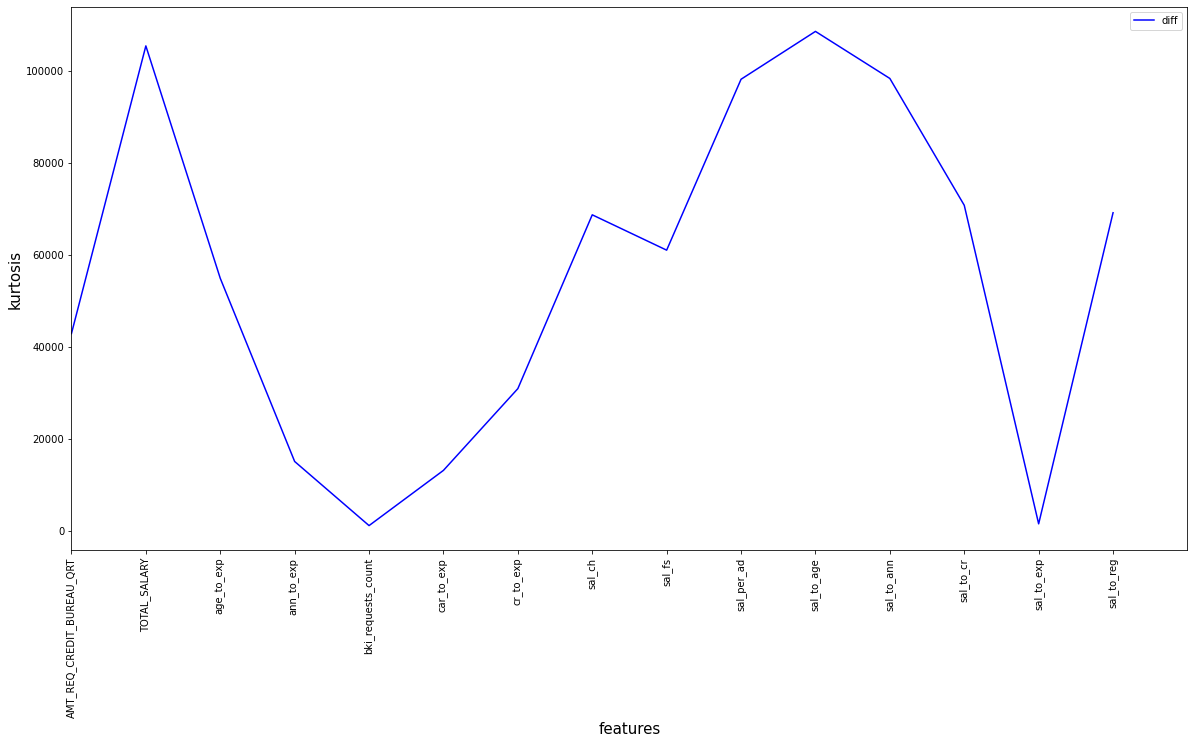

In [61]:
fig = plt.figure(figsize=(20, 10))
plt.plot(my_diff_kurtosis, color="blue", label="diff")
plt.xticks(range(my_diff_kurtosis.shape[0]), my_diff_kurtosis.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(my_diff_kurtosis))
plt.ylabel("kurtosis", size=15)
plt.legend(loc="best") 
plt.show()

In [65]:
my_features =  decrease_scores[decrease_scores['importance-mean']>=0.00000001]['features'].to_list()
len(my_features)

33

In [222]:
my_features

['ESR_mean',
 'am_to_ann',
 'EXTERNAL_SCORING_RATING_3',
 'NAME_CONTRACT_TYPE',
 'EDUCATION_LEVEL',
 'GENDER',
 'EXTERNAL_SCORING_RATING_1',
 'OWN_CAR_AGE',
 'REGION_POPULATION',
 'cr_to_age',
 'external_scoring_prod',
 'FAMILY_STATUS',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AGE',
 'EXTERNAL_SCORING_RATING_2',
 'ann_to_exp',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'sal_to_ann',
 'an_per_ad',
 'asr_2*cr',
 'AMOUNT_ANNUITY',
 'bki_kurtosis',
 'age_to_exp',
 'asr_1*an',
 'car_to_exp',
 'FLAG_PHONE',
 'external_scoring_weighet',
 'sal_fs',
 'sal_per_ad',
 'ESR_max',
 'TOTAL_SALARY',
 'ESR_median',
 'bki_skew']

In [81]:
np.save( PATCH + 'my_features_min_lgb_cl.npy', np.array(my_features))

In [66]:
%%time
res =make_cross_validation(w_train[my_features],\
                           w_train['TARGET'],model_lgb, roc_auc_score, cv_strategy)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.739, valid-score = 0.7332
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7385, valid-score = 0.7323
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7387, valid-score = 0.7279
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7396, valid-score = 0.7203
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7397, valid-score = 0.7277
CV-results train: 0.7391 +/- 0.0
CV-results valid: 0.7283 +/- 0.005
OOF-score = 0.728
Wall time: 15.9 s


In [69]:
for i in c[0]:
    print(i.best_iteration_)

217
217
217
217
217


In [68]:
%%time
result  = []
for i in range(50):
    x,x_v, y,y_v = train_test_split(w_train[my_features],w_train['TARGET'],\
                                                     test_size= 0.2,random_state = i)
    model_lgb.fit(x,y)
    pred = model_lgb.predict_proba(x_v)[:,1]
    result.append(roc_auc_score(y_v,pred))
result = np.array(result)
result.mean(),result.std(),result.min(),result.max()

Wall time: 2min 12s


(0.7324832029077919,
 0.0056179358181029865,
 0.7208335655192547,
 0.7476108246686182)

#### Подбор для lgb

In [155]:
class LGBMClassifier_optimize_params():

    def __init__(self,X,Y,**param):
        from  lightgbm import LGBMClassifier
        from bayes_opt import BayesianOptimization
        from sklearn.metrics import  roc_auc_score
        from sklearn.model_selection import train_test_split
        self.params = param
        n = 0.2
        self.rnd =2
        if 'n' in param.keys():
            n = param['n']
        if 'rnd' in param.keys():
            rnd = param['rnd']    
        self.x ,self.x_v, self.y,self.y_v = train_test_split(X,Y,\
                                                     test_size= n,random_state = self.rnd)
        
        
    def get_work_params(self,params,s_params):
        
        for k,i in s_params.items():
            if k == "max_depth":
                params["max_depth"] = int(i)
            elif k == "num_leaves":     
                params["num_leaves"] = int(i)
            elif k == "min_child_weight":
                params["min_child_weight"] = i
            elif k == "subsample_for_bin":
                params["subsample_for_bin"] = int(i)
            elif k == "min_child_samples":
                params["min_child_samples"] = int(i)
            elif k == "subsample": 
                params["subsample"] = i
            elif k == "colsample_bytree": 
                params["colsample_bytree"] = i
            elif k == "reg_alpha": 
                params["reg_alpha"] = i
            elif k == "reg_lambda": 
                params["reg_lambda"] = i
            elif k == "n_estimators": 
                params["n_estimators"] = i
            elif k == "learning_rate": 
                params["learning_rate"] = i 

    def lgb_optimize_params(self,**s_params):

        params = {}
        params['n_estimators'] = 4000
        params['learning_rate'] = 0.2
        self.get_work_params(params,s_params) 

    
        model = LGBMClassifier(**params)
        model.fit(self.x, self.y, eval_set=[(self.x, self.y),(self.x_v,self.y_v)],\
                                  eval_metric = 'auc',early_stopping_rounds = 90,verbose=None) 
        pred = model.predict_proba(self.x_v)[:,1]

        return roc_auc_score(self.y_v, pred)    
    
    def run(self,params_search,init_points=10, n_iter=1000, acq='ei'):
        self.lgm_params_search = BayesianOptimization(
                self.lgb_optimize_params,
                pbounds=  params_search,
                random_state=self.rnd)
        self.lgm_params_search.maximize(init_points=init_points, n_iter=n_iter, acq=acq
        )
        
        res = self.lgm_params_search.max
        self.best_target = res['target']
        self.best_params = {}
        self.get_work_params(self.best_params,res['params'])
  
    
        
        return self.best_target, self.best_params, self.lgm_params_search
        
        
    
    

In [156]:
lgb_serch_param = LGBMClassifier_optimize_params(w_train[my_features],w_train['TARGET'])

In [157]:
res_lgb_search = lgb_serch_param.run(params_search,n_iter = 10)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6805   |  0.6052   |  2.207    |  56.32    |  43.53    |  44.93    |  991.0    |  613.9    |  0.8477   |  1.568e+0 |
|  2        |  0.6924   |  0.4868   |  6.969    |  54.33    |  13.46    |  53.79    |  553.3    |  2.356e+0 |  0.9416   |  2.522e+0 |
|  3        |  0.7016   |  0.8926   |  2.637    |  52.01    |  6.529    |  45.67    |  289.6    |  381.5    |  0.8387   |  1.207e+0 |
|  4        |  0.5      |  0.3749   |  3.762    |  36.93    |  46.78    |  24.17    |  1.921e+0 |  1.449e+0 |  0.8021   |  1.996e+0 |
|  5        |  0.6605   |  0.8555   |  6.64     |  18.74    |  70.08    |  96.63    |  1.5e+03  |  2.669e+0 |  0.7366   |  2.879e+0 |
|  6        |  0.6599   |  0.5993   |  5.494    |  78.33    | 

In [154]:
res_lgb_search

(0.7284839859927843,
 {'colsample_bytree': 0.4818213269229959,
  'max_depth': 5,
  'min_child_samples': 83,
  'min_child_weight': 73.6747056287113,
  'num_leaves': 41,
  'reg_alpha': 39.052010083651886,
  'reg_lambda': 2392.2148170977807,
  'subsample': 0.7077555190385205,
  'subsample_for_bin': 295515},
 <bayes_opt.bayesian_optimization.BayesianOptimization at 0x28e1955f7c0>)

In [111]:
x,x_v, y,y_v = train_test_split(w_train[my_features],w_train['TARGET'],\
                                                     test_size= 0.2,random_state = 2)

In [115]:
lgm_params_search.max

{'target': 0.7330969681742914,
 'params': {'colsample_bytree': 0.9145385274964326,
  'max_depth': 3.7039141455668734,
  'min_child_samples': 50.35517678001718,
  'min_child_weight': 7.488998395996904,
  'num_leaves': 68.32597501028945,
  'reg_alpha': 0.09185729405281062,
  'reg_lambda': 341.5992894441112,
  'subsample': 0.9733654264015378,
  'subsample_for_bin': 91158.1002805162}}

In [106]:
lgm_params_search.max

{'target': 0.7329267852597812,
 'params': {'colsample_bytree': 0.7679459311915008,
  'max_depth': 3.305290615262856,
  'min_child_samples': 72.2107153428042,
  'min_child_weight': 94.31337698048561,
  'num_leaves': 58.364232075543484,
  'reg_alpha': 13.336298472599871,
  'reg_lambda': 17.1409552906846,
  'subsample': 0.9660240236279869,
  'subsample_for_bin': 238299.18846320236}}

In [182]:
params_lgb = {'colsample_bytree': 0.7679459311915008,
  'max_depth': 3,
  'min_child_samples': 72,
  'min_child_weight': 94.31337698048561,
  'num_leaves': 58,
  'reg_alpha': 13.336298472599871,
  'reg_lambda': 17.1409552906846,
  'subsample': 0.9660240236279869,
  'subsample_for_bin': 238299,
   'learning_rate' :0.05,
   'n_estimators':1000       
          
         }

In [183]:
model_lgb=LGBMClassifier(**params_lgb)

In [184]:
%%time
result  = []
for i in range(20):
    x,x_v, y,y_v = train_test_split(w_train[my_features],w_train['TARGET'],\
                                                     test_size= 0.2,random_state = i)
    model_lgb.fit(x,y)
    pred = model_lgb.predict_proba(x_v)[:,1]
    result.append(roc_auc_score(y_v,pred))
result = np.array(result)
result.mean(),result.std(),result.min(),result.max()

Wall time: 36 s


(0.7309724445113253,
 0.0042512642384040416,
 0.7223229201637809,
 0.7404108082164456)

In [192]:
def test_hold_out_rnd(X,Y,model, n=50):
    result  = []
    for i in range(20):
        x,x_v, y,y_v = train_test_split(X,Y,test_size= 0.2,random_state = i)
        model_lgb.fit(x,y)
        pred = model_lgb.predict_proba(x_v)[:,1]
        result.append(roc_auc_score(y_v,pred))
    result = np.array(result)
    return result.mean(),result.std(),result.min(),result.max()
    

In [203]:
%%time
for eta in [0.01]:
    for n_estimators in [5000]:
        params_lgb['n_estimators'] = n_estimators
        params_lgb['learning_rate'] = eta
        model_lgb = LGBMClassifier(**params_lgb)
        print(n_estimators,eta)
        print(test_hold_out_rnd(w_train[my_features],w_train['TARGET'],model_lgb))
        

5000 0.01
(0.7312447132088096, 0.004369927965882303, 0.722283533363453, 0.7404701417731591)
Wall time: 4min 29s


In [223]:
# 400 0.1
# (0.7309577734805031, 0.00453923714426949, 0.7226440381063992, 0.7415583456487741)
# 800 0.05
# (0.7309608503871664, 0.004188047486045581, 0.7223997409272698, 0.7402142957016791)
# 3000 0.01
# (0.7307494382698916, 0.004479958228326634, 0.7226547924631926, 0.7406092619428829)
# 4000 0.01
# (0.7313223153675278, 0.004428730989381086, 0.7231469899435488, 0.7407609577882115)
# 4500 0.01
# (0.7313228156643918, 0.004435375773272527, 0.7225422430309705, 0.7410596793174588)


In [224]:
%%time
cv_strategy = StratifiedKFold(n_splits=10,random_state = 41,shuffle =True)
params_lgb['n_estimators'] = 800
params_lgb['learning_rate'] = 0.05
model_lgb = LGBMClassifier(**params_lgb)
res =make_cross_validation(w_train[my_features],\
                           w_train['TARGET'],model_lgb, roc_auc_score, cv_strategy)

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7446, valid-score = 0.733
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7531, valid-score = 0.7401
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.7498, valid-score = 0.7369
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7521, valid-score = 0.7329
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7473, valid-score = 0.7215
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.746, valid-score = 0.7389
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7523, valid-score = 0.7315
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7445, valid-score = 0.7196
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7558, valid-score = 0.7282
Fold: 10, train-observations = 99084, v

In [212]:
%%time
cv_strategy = StratifiedKFold(n_splits=5,random_state = 41,shuffle =True)
params_lgb['n_estimators'] = 800
params_lgb['learning_rate'] = 0.05
model_lgb = LGBMClassifier(**params_lgb)
res =make_cross_validation(w_train[my_features],\
                           w_train['TARGET'],model_lgb, roc_auc_score, cv_strategy)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7504, valid-score = 0.7339
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7538, valid-score = 0.7336
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.749, valid-score = 0.7295
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7523, valid-score = 0.724
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7484, valid-score = 0.729
CV-results train: 0.7508 +/- 0.002
CV-results valid: 0.73 +/- 0.004
OOF-score = 0.7297
Wall time: 22.2 s


In [213]:
%%time
cv_strategy = StratifiedKFold(n_splits=10,random_state = 41,shuffle =True)
params_lgb['n_estimators'] = 4500
params_lgb['learning_rate'] = 0.01
model_lgb = LGBMClassifier(**params_lgb)
res =make_cross_validation(w_train.drop('TARGET',axis = 1),\
                           w_train['TARGET'],model_lgb, roc_auc_score, cv_strategy)

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7361, valid-score = 0.7305
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.704, valid-score = 0.7041
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.7424, valid-score = 0.7335
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7249, valid-score = 0.7246
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7353, valid-score = 0.7152
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7401, valid-score = 0.7344
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7413, valid-score = 0.7268
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7366, valid-score = 0.7136
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7283, valid-score = 0.7119
Fold: 10, train-observations = 99084, 

In [214]:
%%time
cv_strategy = StratifiedKFold(n_splits=5,random_state = 41,shuffle =True)
params_lgb['n_estimators'] = 4500
params_lgb['learning_rate'] = 0.01
model_lgb = LGBMClassifier(**params_lgb)
res =make_cross_validation(w_train.drop('TARGET',axis = 1),\
                           w_train['TARGET'],model_lgb, roc_auc_score, cv_strategy)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7419, valid-score = 0.7313
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7439, valid-score = 0.732
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7354, valid-score = 0.7245
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7378, valid-score = 0.7171
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7408, valid-score = 0.7237
CV-results train: 0.7399 +/- 0.003
CV-results valid: 0.7257 +/- 0.005
OOF-score = 0.7253
Wall time: 58.7 s


In [196]:
w_train[my_features].to_csv(PATCH+'w_train_cl_1.csv',index=False)
w_test[my_features].to_csv(PATCH+'w_test_cl_1.csv',index=False)

## Подготовка результатов

#### LGBMClassifier

In [219]:
%%time
model_lgb.fit(w_train[my_features],w_train['TARGET'],verbose = False)

Wall time: 2.73 s


LGBMClassifier(colsample_bytree=0.7679459311915008, learning_rate=0.05,
               max_depth=3, min_child_samples=72,
               min_child_weight=94.31337698048561, n_estimators=800,
               num_leaves=58, reg_alpha=13.336298472599871,
               reg_lambda=17.1409552906846, subsample=0.9660240236279869,
               subsample_for_bin=238299)

In [ ]:
# LB = 73240

# LGBMClassifier(colsample_bytree=0.7679459311915008, learning_rate=0.05,
#                max_depth=3, min_child_samples=72,
#                min_child_weight=94.31337698048561, n_estimators=800,
#                num_leaves=58, reg_alpha=13.336298472599871,
#                reg_lambda=17.1409552906846, subsample=0.9660240236279869,
#                subsample_for_bin=238299)
# w_train[my_features]
# ['ESR_mean',
#  'am_to_ann',
#  'EXTERNAL_SCORING_RATING_3',
#  'NAME_CONTRACT_TYPE',
#  'EDUCATION_LEVEL',
#  'GENDER',
#  'EXTERNAL_SCORING_RATING_1',
#  'OWN_CAR_AGE',
#  'REGION_POPULATION',
#  'cr_to_age',
#  'external_scoring_prod',
#  'FAMILY_STATUS',
#  'AMT_REQ_CREDIT_BUREAU_YEAR',
#  'AGE',
#  'EXTERNAL_SCORING_RATING_2',
#  'ann_to_exp',
#  'AMT_REQ_CREDIT_BUREAU_QRT',
#  'sal_to_ann',
#  'an_per_ad',
#  'asr_2*cr',
#  'AMOUNT_ANNUITY',
#  'bki_kurtosis',
#  'age_to_exp',
#  'asr_1*an',
#  'car_to_exp',
#  'FLAG_PHONE',
#  'external_scoring_weighet',
#  'sal_fs',
#  'sal_per_ad',
#  'ESR_max',
#  'TOTAL_SALARY',
#  'ESR_median',
#  'bki_skew']

In [220]:
pred = model_lgb.predict_proba(w_test[my_features])[:,1]

In [221]:
submission_lgb_base = pd.DataFrame()
submission_lgb_base['APPLICATION_NUMBER'] = w_test['APPLICATION_NUMBER']
submission_lgb_base['TARGET'] = pred
submission_lgb_base.to_csv(PATCH + 'submission_lgb_clients_opt_select_800_005.csv',index=False)

